In [1]:
# create some heat maps for visualization
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#import nbformat # for running in visual studio code
import os

In [2]:
# load data frame
raw_df=pd.read_csv("/Users/scleach/OneDrive - University of Iowa/Research/First_Year_Project/Beh_Data/ThalHi_MRI_2020_RTs.csv")

# initialize lists (will be columns in the new data frame)
sub_list = []
trial_list = []
cue_list = []
cue_prev_list = []
RT_list = []
RT_prev_list = []
RT_diff_list = []
accuracy_list = []
accuracy_prev_list = []
trial_type_list = []
version_list = []

# loop through all rows in the current subject df
total_num_rows = len(raw_df)
print(total_num_rows)
for cur_row in list(range(0,len(raw_df))):
    # if the row is from the first trial in the df, skip, otherwise continue
    if (cur_row > 0):
        #  if the previous row is from another block, skip, otherwise continue
        if (raw_df['block'][cur_row] - raw_df['block'][(cur_row-1)] == 0):
            # if the previous row is more than one trial back, skip, otherwise continue
            if (raw_df['trial_n'][cur_row] - raw_df['trial_n'][(cur_row-1)] == 1):
                # make sure RT isn't too slow (<150)
                cur_Acc = raw_df['trial_Corr'][cur_row]
                prev_Acc = raw_df['trial_Corr'][(cur_row-1)]
                # cur_RT = raw_df['rt'][cur_row]
                # prev_RT = raw_df['rt'][(cur_row-1)]
                cur_RT_z = raw_df['RT_z'][cur_row]
                prev_RT_z = raw_df['RT_z'][(cur_row-1)]
                #if (abs(cur_RT_z) < 3 and abs(prev_RT_z) < 3):
                if ((abs(cur_RT_z) < 3 and abs(prev_RT_z) < 3) and (cur_Acc==1 and prev_Acc==1)):
                    # get current sub and trial number
                    sub_list.append(raw_df['sub'][cur_row])
                    trial_list.append(raw_df['trial_n'][cur_row])
                    # get cue and RT for current trial and previous trial for new df
                    cue_list.append(raw_df['cue'][cur_row])
                    cue_prev_list.append(raw_df['cue'][(cur_row-1)])
                    # calculate change in RT and put in new df
                    RT_list.append(cur_RT_z)
                    RT_prev_list.append(prev_RT_z)
                    RT_diff_list.append(cur_RT_z - prev_RT_z)
                    # put accuracy for curent trial and previous trial in df
                    accuracy_list.append(raw_df['trial_Corr'][cur_row])
                    accuracy_prev_list.append(raw_df['trial_Corr'][(cur_row-1)])
                    # get trial type and version for lists
                    trial_type_list.append(raw_df['Trial_type'][cur_row])
                    version_list.append(raw_df['version'][cur_row])


# initialize the new data frame
column_names = ['sub','trial_num','cue','cue_prev','RT','RT_prev','RT_diff','accuracy','accuracy_prev','trial_type','version']
new_df = pd.DataFrame([sub_list, 
                       trial_list, 
                       cue_list, 
                       cue_prev_list, 
                       RT_list, 
                       RT_prev_list, 
                       RT_diff_list, 
                       accuracy_list, 
                       accuracy_prev_list, 
                       trial_type_list, 
                       version_list], index = column_names).T

# change cue names
new_df["cue"].replace({'dcr': 1,'dcb':2,'dpr':3,'dpb':4,'fcr':5,'fpr':6,'fcb':7,'fpb':8}, inplace=True)
new_df["cue_prev"].replace({'dcr': 1,'dcb':2,'dpr':3,'dpb':4,'fcr':5,'fpr':6,'fcb':7,'fpb':8}, inplace=True)
new_df['cue_index'] = new_df['cue'].to_numpy(dtype=int) * new_df['cue_prev'].to_numpy(dtype=int) + ((new_df['cue'].to_numpy(dtype=int)-1) * (8-new_df['cue_prev'].to_numpy(dtype=int)))
# add other version name to data frame
new_df["version"][new_df["version"].isna()]="Donut=Color,Filled=Shape"
# create a data frame with only DSFC trials
df_DSFC=new_df[new_df["version"]=="Donut=Shape,Filled=Color"]
# create a data frame with only DCFS trials 
df_DCFS=new_df[new_df["version"]=="Donut=Color,Filled=Shape"]
#df_DCFS["sub"].unique()


23455


/var/folders/6w/c1vz3pjn7yx803r5v6fgt7nhvjh7gw/T/ipykernel_29100/3840639345.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["version"][new_df["version"].isna()]="Donut=Color,Filled=Shape"


In [3]:
new_df["sub"]=new_df["sub"].astype('float')
new_df["RT_diff"]=new_df["RT_diff"].astype('float')
new_df["trial_type"]=new_df["trial_type"].astype('category')

new_df[["sub","RT_diff","trial_type"]].dtypes

sub            float64
RT_diff        float64
trial_type    category
dtype: object

In [24]:
# save out new df
#new_df.to_csv('/Users/stephaniecleach/Documents/Visual_Studio_Code/ThalHi_MRI_RT_Cleaned.csv')


In [9]:
# just set up a couple basic t-tests
from scipy.stats import ttest_ind
import scipy.stats as stats
import statsmodels.api as sm
import researchpy as rp

Stay_cond = new_df[new_df["trial_type"]=="Stay"]
IDS_cond = new_df[new_df["trial_type"]=="IDS"]
EDS_cond = new_df[new_df["trial_type"]=="EDS"]

# Stay_cond = df_DCFS[df_DCFS["trial_type"]=="Stay"]
# IDS_cond = df_DCFS[df_DCFS["trial_type"]=="IDS"]
# EDS_cond = df_DCFS[df_DCFS["trial_type"]=="EDS"]

print("T-tests not splitting by pre vs post covid")
print(ttest_ind(Stay_cond["RT_diff"],IDS_cond["RT_diff"]))
print(ttest_ind(Stay_cond["RT_diff"],EDS_cond["RT_diff"]))
print(ttest_ind(IDS_cond["RT_diff"],EDS_cond["RT_diff"]))


Stay_cond_pre  = Stay_cond[Stay_cond["sub"]<=10026] #ids <= 10026 are pre covid
Stay_cond_post = Stay_cond[Stay_cond["sub"]>=10027] #ids >= 10027 are post covid
IDS_cond_pre  = IDS_cond[IDS_cond["sub"]<=10026] #ids <= 10026 are pre covid
IDS_cond_post = IDS_cond[IDS_cond["sub"]>=10027] #ids >= 10027 are post covid
EDS_cond_pre  = EDS_cond[EDS_cond["sub"]<=10026] #ids <= 10026 are pre covid
EDS_cond_post = EDS_cond[EDS_cond["sub"]>=10027] #ids >= 10027 are post covid

print("\nT-tests when splitting by pre and post COVID")
print("PRE-COVID: with ", len(Stay_cond_pre["sub"].unique()), "subjects")
print(ttest_ind(Stay_cond_pre["RT_diff"],IDS_cond_pre["RT_diff"]))
print(ttest_ind(Stay_cond_pre["RT_diff"],EDS_cond_pre["RT_diff"]))
print(ttest_ind(IDS_cond_pre["RT_diff"],EDS_cond_pre["RT_diff"]))
print("POST-COVID: with ", len(Stay_cond_post["sub"].unique()), "subjects")
print(ttest_ind(Stay_cond_post["RT_diff"],IDS_cond_post["RT_diff"]))
print(ttest_ind(Stay_cond_post["RT_diff"],EDS_cond_post["RT_diff"]))
print(ttest_ind(IDS_cond_post["RT_diff"],EDS_cond_post["RT_diff"]))


T-tests not splitting by pre vs post covid
Ttest_indResult(statistic=-6.924970660427928, pvalue=4.68876066558321e-12)
Ttest_indResult(statistic=-11.427018906439585, pvalue=5.203241079245395e-30)
Ttest_indResult(statistic=-3.8870323115307106, pvalue=0.00010281319125606057)

T-tests when splitting by pre and post COVID
PRE-COVID: with  26 subjects
Ttest_indResult(statistic=-3.599550159873827, pvalue=0.00032304665660069375)
Ttest_indResult(statistic=-7.9573225376333045, pvalue=2.3345325849663583e-15)
Ttest_indResult(statistic=-3.594701127069987, pvalue=0.0003320450800546152)
POST-COVID: with  31 subjects
Ttest_indResult(statistic=-6.063769707118446, pvalue=1.4360203991210177e-09)
Ttest_indResult(statistic=-8.201897352699953, pvalue=3.060445591558787e-16)
Ttest_indResult(statistic=-1.993327343813263, pvalue=0.046323966085510156)


In [7]:
rp.summary_cont(new_df.groupby(["version","trial_type"])["RT_diff"])

N    Mean      SD      SE  95% Conf.  \
version                  trial_type                                            
Donut=Color,Filled=Shape EDS         2605  0.9314  4.7020  0.0921     0.7507   
                         IDS         2535  0.1901  4.6697  0.0927     0.0082   
                         Stay        5593 -0.5140  4.2269  0.0565    -0.6248   
Donut=Shape,Filled=Color EDS         2437  0.8796  4.5836  0.0928     0.6976   
                         IDS         2488 -0.0242  4.6333  0.0929    -0.2063   
                         Stay        5421 -0.3956  4.1056  0.0558    -0.5049   

                                     Interval  
version                  trial_type            
Donut=Color,Filled=Shape EDS           1.1120  
                         IDS           0.3719  
                         Stay         -0.4032  
Donut=Shape,Filled=Color EDS           1.0617  
                         IDS           0.1579  
                         Stay         -0.2863

In [10]:
rp.summary_cont(new_df.groupby(["trial_type"])["RT_diff"])

,N,Mean,SD,SE,95% Conf.,Interval
trial_type,,,,,,
EDS,2394,0.3495,2.2240,0.0455,0.2603,0.4386
IDS,2527,0.1048,2.1908,0.0436,0.0193,0.1902
Stay,5696,-0.2504,2.1255,0.0282,-0.3056,-0.1952


In [11]:
import statsmodels.formula.api as smf

model = smf.mixedlm("RT_diff ~ C(trial_type, Treatment('Stay'))",
                    new_df[["RT_diff","trial_type","sub"]],
                    groups="sub").fit()

model.summary()

/Users/scleach/Library/Python/3.8/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/scleach/Library/Python/3.8/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/scleach/Library/Python/3.8/lib/python/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
==================================================================================
Model:                     MixedLM         Dependent Variable:         RT_diff    
No. Observations:          10617           Method:                     REML       
No. Groups:                57              Scale:                      4.6840     
Min. group size:           7               Log-Likelihood:             -23267.5264
Max. group size:           259             Converged:                  Yes        
Mean group size:           186.3                                                  
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               -0.201    0.024 -8.529 0.000 -0.247 -0.154
C(trial_type, Treatment('Stay'))[T.EDS]  0.604    0.053 11.462 0.000  0.501  0.707
C(trial_type, Treatment('Stay'))[T.IDS]  0.352    0.052  6.807 0.000  0.251  0.453
sub Var                                  0.000                                    
==================================================================================

"""

/var/folders/6w/c1vz3pjn7yx803r5v6fgt7nhvjh7gw/T/ipykernel_5032/1549600857.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['RT_diff'] = df_DSFC['RT_diff'].to_numpy(dtype=float)


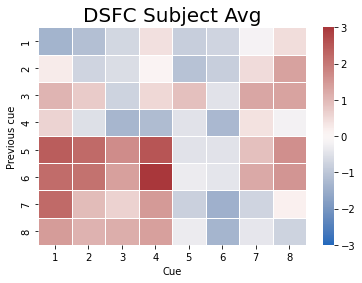

In [20]:
# create some heat maps for visualization
import seaborn as sns
import matplotlib.pylab as plt
import nbformat # for running code in visual studio code
import os

test = df_DSFC
test['RT_diff'] = df_DSFC['RT_diff'].to_numpy(dtype=float)
#reduce to only accurate trials (current and previous)
#test = test[test["accuracy"].to_numpy(dtype=float)==1]
#test = test[test["accuracy_prev"].to_numpy(dtype=float)==1]
# group by cue and previous cue
testavg = test.groupby(['cue','cue_prev'])['RT_diff'].mean().reset_index()
#check for missing cues and prev cues
ccs = testavg['cue'].unique() # make list of current cues for current cue
for cc in range(1,9): # loop through all the possible cues
    temp_testavg = testavg[testavg['cue']==cc] # pull out only the rows for the current cue
    if (not(any(cc==ccs))): # if current cue is missing a number
        for cnum in range(1,9):
            testavg = testavg.append({'RT_diff':0,'cue':cc,'cue_prev':cnum}, ignore_index=True)
    ccps = temp_testavg['cue_prev'].unique() # make list of current previous cues for current cue
    #print(ccps)
    for ccp in range(1,9): # loop through all possible previous cues
        if (not(any(ccp==ccps))): # if actual previous cues are missing a number
            print(cc,ccp)
            testavg = testavg.append({'RT_diff':0,'cue':cc,'cue_prev':ccp}, ignore_index=True)

# for b in bins:
bin1 = testavg[testavg['cue_prev']==1]['RT_diff']
bin2 = testavg[testavg['cue_prev']==2]['RT_diff']
bin3 = testavg[testavg['cue_prev']==3]['RT_diff']
bin4 = testavg[testavg['cue_prev']==4]['RT_diff']
bin5 = testavg[testavg['cue_prev']==5]['RT_diff']
bin6 = testavg[testavg['cue_prev']==6]['RT_diff']
bin7 = testavg[testavg['cue_prev']==7]['RT_diff']
bin8 = testavg[testavg['cue_prev']==8]['RT_diff']

# data=np.asarray([bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8],dtype=float)
data=np.asarray([bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8],dtype=float)

arrs = []
for b in data: 
    arrs = np.append(arrs,b)
arrs

#make plot
x_axis_labels = [1,2,3,4,5,6,7,8]
y_axis_labels = [1,2,3,4,5,6,7,8]
ax = sns.heatmap(data, linewidth=0.5, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="vlag", vmin=-3, vmax=3)
plt.xlabel("Cue")
plt.ylabel("Previous cue")
plt.title('DSFC Subject Avg', fontsize=20)

plt.show()

/var/folders/6w/c1vz3pjn7yx803r5v6fgt7nhvjh7gw/T/ipykernel_5032/3494194704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['RT_diff'] = df_DCFS['RT_diff'].to_numpy(dtype=float)


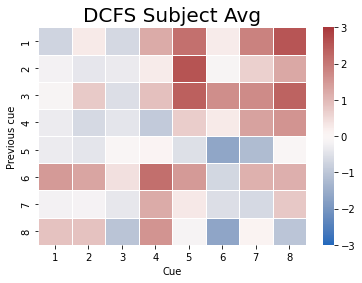

In [26]:
# create some heat maps for visualization
import seaborn as sns
import matplotlib.pylab as plt
import nbformat
import os

test = df_DCFS
test['RT_diff'] = df_DCFS['RT_diff'].to_numpy(dtype=float)
#reduce to only accurate trials (current and previous)
#test = test[test["accuracy"].to_numpy(dtype=float)==1]
#test = test[test["accuracy_prev"].to_numpy(dtype=float)==1]
# group by cue and previous cue
testavg = test.groupby(['cue','cue_prev'])['RT_diff'].mean().reset_index()
#check for missing cues and prev cues
ccs = testavg['cue'].unique() # make list of current cues for current cue
for cc in range(1,9): # loop through all the possible cues
    temp_testavg = testavg[testavg['cue']==cc] # pull out only the rows for the current cue
    if (not(any(cc==ccs))): # if current cue is missing a number
        for cnum in range(1,9):
            testavg = testavg.append({'RT_diff':0,'cue':cc,'cue_prev':cnum}, ignore_index=True)
    ccps = temp_testavg['cue_prev'].unique() # make list of current previous cues for current cue
    #print(ccps)
    for ccp in range(1,9): # loop through all possible previous cues
        if (not(any(ccp==ccps))): # if actual previous cues are missing a number
            print(cc,ccp)
            testavg = testavg.append({'RT_diff':0,'cue':cc,'cue_prev':ccp}, ignore_index=True)

# for b in bins:
bin1 = testavg[testavg['cue_prev']==1]['RT_diff']
bin2 = testavg[testavg['cue_prev']==2]['RT_diff']
bin3 = testavg[testavg['cue_prev']==3]['RT_diff']
bin4 = testavg[testavg['cue_prev']==4]['RT_diff']
bin5 = testavg[testavg['cue_prev']==5]['RT_diff']
bin6 = testavg[testavg['cue_prev']==6]['RT_diff']
bin7 = testavg[testavg['cue_prev']==7]['RT_diff']
bin8 = testavg[testavg['cue_prev']==8]['RT_diff']

# data=np.asarray([bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8],dtype=float)
data=np.asarray([bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8],dtype=float)

arrs = []
for b in data: 
    arrs = np.append(arrs,b)
arrs

#make plot
x_axis_labels = [1,2,3,4,5,6,7,8]
y_axis_labels = [1,2,3,4,5,6,7,8]
ax = sns.heatmap(data, linewidth=0.5, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="vlag", vmin=-3, vmax=3)
plt.xlabel("Cue")
plt.ylabel("Previous cue")
plt.title('DCFS Subject Avg', fontsize=20)

plt.show()

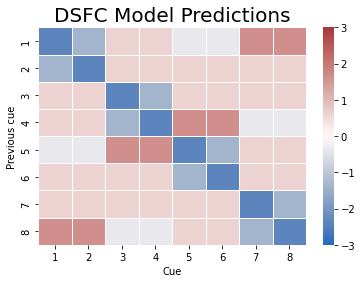

0.0


In [42]:
#create heatmap of expected effect with model info considered

data_base= np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0], 
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0]])

data_HL=np.array([[0, 0, 0, 0, 1, 1, 1, 1],
                [0, 0, 0, 0, 1, 1, 1, 1], 
                [0, 0, 0, 0, 1, 1, 1, 1],
                [0, 0, 0, 0, 1, 1, 1, 1],
                [1, 1, 1, 1, 0, 0, 0, 0],
                [1, 1, 1, 1, 0, 0, 0, 0],
                [1, 1, 1, 1, 0, 0, 0, 0],
                [1, 1, 1, 1, 0, 0, 0, 0]])

data_Iden= np.array([[-1, 0, 0, 0, 0, 0, 0, 0],
            [0, -1, 0, 0, 0, 0, 0, 0], 
            [0, 0, -1, 0, 0, 0, 0, 0],
            [0, 0, 0, -1, 0, 0, 0, 0],
            [0, 0, 0, 0, -1, 0, 0, 0],
            [0, 0, 0, 0, 0, -1, 0, 0],
            [0, 0, 0, 0, 0, 0, -1, 0],
            [0, 0, 0, 0, 0, 0, 0, -1]])+1

# 0 means looking at same feature (color or shape) of cue
# 1 means looking at diff feature (color or shape) of cue
# data_relF= np.array([[-1, 0, 1, 1, 0, 0, 1, 1],
#             [0, -1, 1, 1, 1, 1, 0, 0], 
#             [1, 1, -1, 0, 0, 0, 1, 1],
#             [1, 1, 0, -1, 1, 1, 0, 0],
#             [0, 0, 1, 1, -1, 0, 1, 1],
#             [1, 1, 0, 0, 0, -1, 1, 1],
#             [0, 0, 1, 1, 1, 1, -1, 0],
#             [1, 1, 0, 0, 1, 1, 0, -1]])
data_relF= np.array([[0, 0, 1, 1, 0, 0, 1, 1],
                    [0, 0, 1, 1, 1, 1, 0, 0], 
                    [1, 1, 0, 0, 0, 0, 1, 1],
                    [1, 1, 0, 0, 1, 1, 0, 0],
                    [0, 0, 1, 1, 0, 0, 1, 1],
                    [1, 1, 0, 0, 0, 0, 1, 1],
                    [0, 0, 1, 1, 1, 1, 0, 0],
                    [1, 1, 0, 0, 1, 1, 0, 0]])

# 0 means performing same task (face or scene) with this cue
# 1 means performing diff task (face or scene) with this cue
data_tskR= np.array([[0, 0, 1, 1, 0, 0, 1, 1],
                     [0, 0, 1, 1, 0, 0, 1, 1], 
                     [1, 1, 0, 0, 1, 1, 0, 0],
                     [1, 1, 0, 0, 1, 1, 0, 0],
                     [0, 0, 1, 1, 0, 0, 1, 1],
                     [0, 0, 1, 1, 0, 0, 1, 1],
                     [1, 1, 0, 0, 1, 1, 0, 0],
                     [1, 1, 0, 0, 1, 1, 0, 0]])


data = data_base + data_HL + data_relF + data_tskR + data_Iden
data = data - data.mean() # recenter around mean
DSFC_data = data
#data = data_base + data_HL + data_Iden 

#make plot
x_axis_labels = [1,2,3,4,5,6,7,8]
y_axis_labels = [1,2,3,4,5,6,7,8]
#ax = sns.heatmap(data, linewidth=0.5, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="vlag", vmin=-3, vmax=3)
ax = sns.heatmap(data, linewidth=0.5, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="vlag", vmin=-3, vmax=3)
plt.xlabel("Cue")
plt.ylabel("Previous cue")
plt.title('DSFC Model Predictions', fontsize=20)

plt.show()
print(data.mean())


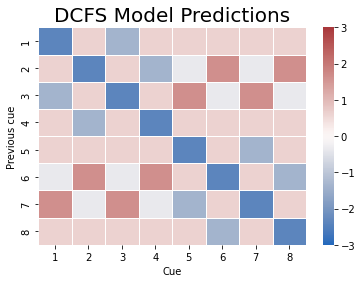

In [43]:
#create heatmap of expected effect with model info considered

data_base= np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0], 
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0]])

data_HL=np.array([[0, 0, 0, 0, 1, 1, 1, 1],
                  [0, 0, 0, 0, 1, 1, 1, 1], 
                  [0, 0, 0, 0, 1, 1, 1, 1],
                  [0, 0, 0, 0, 1, 1, 1, 1],
                  [1, 1, 1, 1, 0, 0, 0, 0],
                  [1, 1, 1, 1, 0, 0, 0, 0],
                  [1, 1, 1, 1, 0, 0, 0, 0],
                  [1, 1, 1, 1, 0, 0, 0, 0]])

data_Iden= np.array([[-1, 0, 0, 0, 0, 0, 0, 0],
            [0, -1, 0, 0, 0, 0, 0, 0], 
            [0, 0, -1, 0, 0, 0, 0, 0],
            [0, 0, 0, -1, 0, 0, 0, 0],
            [0, 0, 0, 0, -1, 0, 0, 0],
            [0, 0, 0, 0, 0, -1, 0, 0],
            [0, 0, 0, 0, 0, 0, -1, 0],
            [0, 0, 0, 0, 0, 0, 0, -1]])+1

# 0 means looking at same feature (color or shape) of cue
# 1 means looking at diff feature (color or shape) of cue
data_relF= np.array([[0, 1, 0, 1, 0, 1, 0, 1],
                     [1, 0, 1, 0, 0, 1, 0, 1], 
                     [0, 1, 0, 1, 1, 0, 1, 0],
                     [1, 0, 1, 0, 1, 0, 1, 0],
                     [0, 1, 0, 1, 0, 1, 0, 1],
                     [0, 1, 0, 1, 1, 0, 1, 0],
                     [1, 0, 1, 0, 0, 1, 0, 1],
                     [1, 0, 1, 0, 1, 0, 1, 0]])

# 0 means performing same task (face or scene) with this cue
# 1 means performing diff task (face or scene) with this cue
data_tskR= np.array([[0, 1, 0, 1, 1, 0, 1, 0],
                     [1, 0, 1, 0, 0, 1, 0, 1], 
                     [0, 1, 0, 1, 1, 0, 1, 0],
                     [1, 0, 1, 0, 0, 1, 0, 1],
                     [1, 0, 1, 0, 0, 1, 0, 1],
                     [0, 1, 0, 1, 1, 0, 1, 0],
                     [1, 0, 1, 0, 0, 1, 0, 1],
                     [0, 1, 0, 1, 1, 0, 1, 0]])


data = data_base + data_HL + data_relF + data_tskR + data_Iden
data = data - data.mean() # recenter around mean
DCFS_data = data
#data = data_base + data_HL  

#make plot
x_axis_labels = [1,2,3,4,5,6,7,8]
y_axis_labels = [1,2,3,4,5,6,7,8]
#ax = sns.heatmap(data, linewidth=0.5, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="vlag", vmin=-3, vmax=3)
ax = sns.heatmap(data, linewidth=0.5, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="vlag", vmin=-3, vmax=3)
plt.xlabel("Cue")
plt.ylabel("Previous cue")
plt.title('DCFS Model Predictions', fontsize=20)

plt.show()


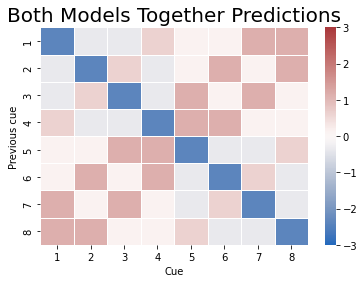

In [46]:
data = (DCFS_data + DSFC_data)/2
#make plot
x_axis_labels = [1,2,3,4,5,6,7,8]
y_axis_labels = [1,2,3,4,5,6,7,8]
#ax = sns.heatmap(data, linewidth=0.5, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="vlag", vmin=-3, vmax=3)
ax = sns.heatmap(data, linewidth=0.5, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="vlag", vmin=-3, vmax=3)
plt.xlabel("Cue")
plt.ylabel("Previous cue")
plt.title('Both Models Together Predictions', fontsize=20)

plt.show()